# Testing

This section describes the evaluation of each of the trained models (the length classifier, AAC classifier, and PLM classifier) on the testing dataset. Each of the models assessed in this notebook is trained using the process described in the `training.ipynb` notebook. The output of the testing pipeline is a series of figures and statistics which report on the performance of the model on the testing data.

If you want to run this code, be sure to modify the `DATA_DIR` variable below to specify where the data will be stored on your machine. `DATA_DIR` is the absolute path specifying the location where the data will be stored


In [2]:
# So you don't need to restart the kernel whenever a module is updated.
%load_ext autoreload
%autoreload 2

In [3]:
DATA_DIR = '/home/prichter/Documents/data/selenobot-test/'

In [4]:
import sys
# Add the selenobot/ subirectory to the module search path, so that the modules in this directory are visible from the notebook.
sys.path.append('../selenobot/')

In [15]:
from dataset import Dataset, get_dataloader 
from embedders import AacEmbedder, LengthEmbedder
from classifiers import Classifier, SimpleClassifier
from utils import csv_size
from plot import *
import pandas as pd
import numpy as np
import pickle
import torch

## Downloading model weights

Pre-trained weights for each of the three models are available for download from a Google Cloud bucket, and can be accessed using the command below. Alternatively, models can be trained from scratch by following the procedure outlined in the `training.ipynb` notebook.

In [5]:
# Download the model weights in the Google Cloud bucket to the data directory for the project. 
! curl 'https://storage.googleapis.com/selenobot-data/weights/plm_model_weights.pth' -o '{DATA_DIR}plm_model_weights.pth'
! curl 'https://storage.googleapis.com/selenobot-data/weights/len_model_weights.pth' -o '{DATA_DIR}len_model_weights.pth'
! curl 'https://storage.googleapis.com/selenobot-data/weights/aac_model_weights.pth' -o '{DATA_DIR}aac_model_weights.pth'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   206  100   206    0     0   1338      0 --:--:-- --:--:-- --:--:--  1346
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   206  100   206    0     0   1978      0 --:--:-- --:--:-- --:--:--  1961
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   206  100   206    0     0   1805      0 --:--:-- --:--:-- --:--:--  1807


## Downloading the testing dataset

A prepared testing dataset is available for download from a Google Cloud bucket. This dataset consists of __ UniProt sequences and PLM embeddings, which were withheld from the training and validation datasets. __ percent of the sequences in this dataset are truncated selenoproteins, while the remaining sequences are SwissProt reviewed full-length proteins. The testing dataset can be accessed using this command below. Alternatively, the dataset can be generated from scratch by following the procedure in the Set-up section.

In [8]:
# Download the testing data from the Google Cloud bucket into the data directory. 
! curl 'https://storage.googleapis.com/selenobot-data/test.csv' -o '{DATA_DIR}test.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  875M  100  875M    0     0  13.4M      0  0:01:04  0:01:04 --:--:-- 13.3M


In [9]:
# Print some information about the testing dataset.  
print('Size the testing dataset:', csv_size(f'{DATA_DIR}test.csv')) # How big is it?

labels = pd.read_csv(f'{DATA_DIR}test.csv', usecols=['label']).label 
print('Selenoprotein content of the testing dataset:', np.sum(labels) / len(labels)) # What is the selenoprotein fraction?

Size the testing dataset: 70565
Selenoprotein content of the testing dataset: 0.04018989584071424


## Testing the models

### Loading pre-trained model weights

First, `Classifier`s with layer dimensions appropriate for each of the three model categories (the length classifier, AAC classifier, and PLM classifier) are instantiated. Then, the weights of pre-trained models can be loaded into newly-instantiated models to avoid re-training. This step  populates the weights of the linear layers in each classifier with the weights reached during prior training. 

In [6]:
# Instantiate each model with the appropriate dimensions.
len_model = SimpleClassifier(latent_dim=1)
aac_model = Classifier(latent_dim=21, hidden_dim=8)
plm_model = Classifier(latent_dim=1024, hidden_dim=512)

In [7]:
# Load the weights in the downloaded (or generated) pth files into the appropriate model.
len_model.load_state_dict(torch.load(f'{DATA_DIR}len_model_weights.pth'))
aac_model.load_state_dict(torch.load(f'{DATA_DIR}aac_model_weights.pth'))
plm_model.load_state_dict(torch.load(f'{DATA_DIR}plm_model_weights.pth'))


<All keys matched successfully>

### Predicting selenoproteins

`Classifier` objects work with data stored in custom `Dataset` objects, which are defined in the `dataset.py` file. So, prior to testing the `Classifiers`, the testing dataset must be loaded into a `Dataset` object. The resulting `Datasets` can then be passed into the `predict` method implemented by the `Classifier` object. The `predict` method puts the model in evaluation mode and runs a forward pass of the model on the input `Dataset`. It returns a `TestReporter` object, which stores the raw model outputs, the targets, and the BCE loss.


In [11]:
# Read the testing dataset into a pandas DataFrame.
# Make sure to set index_col to zero to avoid reading an "Unnamed" column
test_df = pd.read_csv(f'{DATA_DIR}test.csv', index_col=0)

In [12]:
# Instantiate Dataset objects using the testing data.
len_dataset = Dataset(test_df, embedder=LengthEmbedder())
aac_dataset = Dataset(test_df, embedder=AacEmbedder())
plm_dataset = Dataset(test_df, embedder=None)

In [13]:
# Run a forward pass of each model on the testing dataset.
len_reporter = len_model.predict(len_dataset)
aac_reporter = aac_model.predict(aac_dataset)
plm_reporter = plm_model.predict(plm_dataset)

## Evaluating performance

### Accuracies

For each model, the predictions are used to compute the balanced accuracy score. Balanced accuracy accounts for imbalance in the dataset by placing a greater weight on false negatives and true positives when determining accuracy. 


In [14]:
print('Balanced accuracy of length classifier prediction on testing data:', len_reporter.get_balanced_accuracy())
print('Balanced accuracy of AAC classifier prediction on testing data:', aac_reporter.get_balanced_accuracy())
print('Balanced accuracy of PLM classifier prediction on testing data:', plm_reporter.get_balanced_accuracy())

Balanced accuracy of length classifier prediction on testing data: 0.6381822270902804
Balanced accuracy of AAC classifier prediction on testing data: 0.8055870523283779
Balanced accuracy of PLM classifier prediction on testing data: 0.995000396903801


### Receiver-operator curves (ROC)

The ROC is generated by evaluating model performance on the test dataset at various threshold values, i.e. the value above which a model output is considered to indicate a truncated selenoprotein. Then, the false positive (FPR) is plotted against the true positive rate (TPR) for each threshold. The area under the ROC curve (AUC) is also computed, which assesses the ability of a binary classifier to distinguish between two classes. 


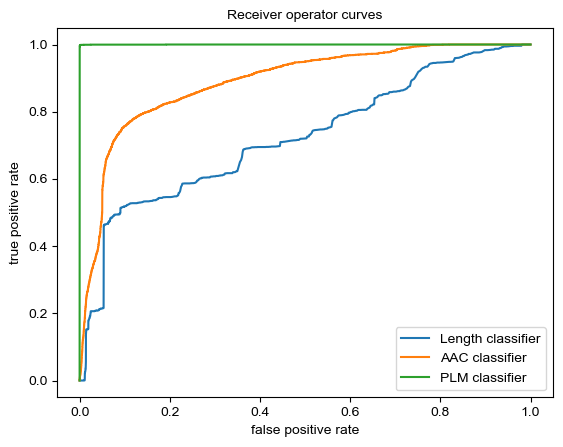

In [24]:
fig, ax = plt.subplots()
plot_receiver_operator_curve(len_reporter, ax=ax)
plot_receiver_operator_curve(aac_reporter, ax=ax)
plot_receiver_operator_curve(plm_reporter, ax=ax)
ax.set_title('Receiver operator curves')
ax.legend(['Length classifier', 'AAC classifier', 'PLM classifier'])
plt.show()

In [27]:
print('Length classifier AUC:', len_reporter.get_auc())
print('AAC classifier AUC:', aac_reporter.get_auc())
print('PLM classifier AUC:', plm_reporter.get_auc())

Length classifier AUC: 0.723342646456833
AAC classifier AUC: 0.890010925595414
PLM classifier AUC: 0.9999108586955076


### Precision-recall curves

Precision recall curves plot the model’s precision (the fraction of true positives to the total number of predicted positives) versus recall (the fraction of true positives to total number of positives in the dataset). Unlike the ROC, precision-recall curves account for dataset imbalance. Because there are many more negative instances (full-length proteins) than positive instances (truncated selenoproteins) in the testing dataset, this plot may allow for a more balanced assessment of model performance. 


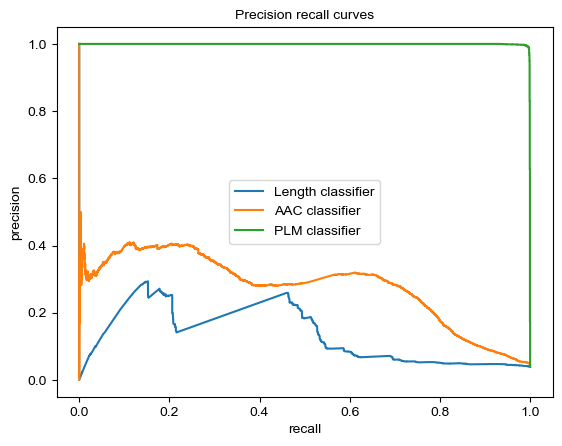

In [26]:
fig, ax = plt.subplots()
plot_precision_recall_curve(len_reporter, ax=ax)
plot_precision_recall_curve(aac_reporter, ax=ax)
plot_precision_recall_curve(plm_reporter, ax=ax)
ax.set_title('Precision recall curves')
ax.legend(['Length classifier', 'AAC classifier', 'PLM classifier'])
plt.show()

### Confusion matrices

Confusion matrices visualize the number of true positives, false positives, true negatives, and false negatives predicted by the model. 
